In [87]:
# import frogress
import pandas as pd
import numpy as np
import sys
from subprocess import call
from scipy.spatial import cKDTree
from astropy.cosmology import FlatLambdaCDM
import glob
from astropy.io import fits
import healpy as hp
import numpy as np;
import astropy.io.fits as pyfits;
from pylab import *
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy import stats
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=100, Om0=0.3)
def fArea(N_rand, Z):
    r = cosmo.comoving_distance(Z).value
    Area = (N_rand*(r**2))/1181810286.0042278

    return Area

# ra,dec 2 xyz
def get_xyz(ra,dec):
    theta = (90-dec)*np.pi/180
    phi = ra*np.pi/180
    z = np.cos(theta)
    y = np.sin(phi)*np.sin(theta)
    x = np.cos(phi)*np.sin(theta)
    return x,y,z


# getting mirror points
@np.vectorize
def get_mirr(ra0,dec0,gra,gdec):
    x0,y0,z0  = get_xyz(ra0,dec0)
    xg,yg,zg  = get_xyz(gra,gdec)
    cos_theta = x0*xg + y0*yg + z0*zg 
    alpha   = y0*zg - yg*z0  
    beta    = x0*zg - xg*z0  
    gamma   = yg*x0 - xg*y0  
    
    num_zm = (2*cos_theta**2 - 1)*(x0*beta + y0*alpha) - cos_theta*(xg*beta + yg*alpha)
    den_zm = yg*(gamma*x0 - alpha*z0) - xg*(beta*z0 + gamma*y0) + zg*(beta*x0 + alpha*y0)
    
    zm = num_zm *1.0/den_zm
    ym = (alpha*cos_theta - zm*(z0*alpha - x0*gamma))*1.0/(x0*beta + y0*alpha)
    xm = (beta*cos_theta - zm*(y0*gamma + z0*beta))*1.0/(x0*beta + y0*alpha)
    r = (xm**2 + ym**2 + zm**2)**0.5
        
    theta = np.arccos(np.clip(zm*1.0/r,-1,1))
    phi = np.arctan(ym*1.0/xm)
    if xm>0 and ym>0:
        phi = phi
    if xm<0 and ym>0:
        phi = np.pi - abs(phi)
    if xm<0 and ym<0:
        phi = np.pi + abs(phi)
    if xm>0 and ym<0:
        phi = 2*np.pi - abs(phi)
        
    ra = phi*180/np.pi
    dec = (np.pi/2 - theta)*180.0/np.pi
    
    return ra,dec

def sep2(mra, mdec, pra, pdec, pzred):
    c1 = SkyCoord(ra=mra*u.degree, dec=mdec*u.degree)
    c2 = SkyCoord(ra=pra*u.degree, dec=pdec*u.degree)
    sep = c1.separation(c2)
    sep.arcsecond

    cosmo = FlatLambdaCDM(H0=100, Om0=0.3)

    d_A = cosmo.comoving_distance(pzred)
    # print(d_A) 

    theta = sep.arcsecond*u.arcsec
    distance_Mpc = (theta * d_A).to(u.Mpc, u.dimensionless_angles())/(1+pzred) # unit is Mpc only now
    
    return distance_Mpc.value


# getting jackknife region
def getregions(ra,dec):
    regionID=np.zeros(len(ra)).astype(int)
    RAMIN,RAMAX,DECMIN,DECMAX=np.loadtxt("/mnt/home/project/cparmeshwar/Minor_project/Annular_radius_0.3_0.6/jackregion_SM.txt", delimiter=" ",unpack=True)
    for ni in range(len(ra)):
        idx= ((RAMIN<ra[ni]) & (RAMAX>ra[ni]) & (DECMIN<dec[ni]) & (DECMAX>dec[ni]))
        regionID[ni]=int(np.where(idx)[0])
    return regionID

def lens_select(Rmin, Rmax, mirror=False, HighSM = False):
    
    cdat = fits.open('/mnt/home/project/cparmeshwar/Minor_project/GAMA/grpGal_smass_sSFR.fits')[1].data
    
    idx = (cdat['Nfof'] >= 15) 
    sSFR = np.log10(cdat['sSFR_0_1Gyr_best_fit'][idx])
    sm = cdat['logmstar'][idx]
    pid = cdat['GroupID_1'][idx]
    pra = cdat['IterCenRA'][idx]
    pdec = cdat['IterCenDec'][idx]
    pzred = cdat['Zfof'][idx]
    
    mra   = cdat['RA'][idx]
    mdec  = cdat['Dec'][idx]
    mrsep = sep2(mra, mdec, pra, pdec, pzred)
    mpid  = cdat['CATAID_1_1'][idx]
    mzred = pzred
    
   
    idx =  (mrsep>Rmin) & (mrsep<Rmax) # &(sm>10.2) & (sm<11.5) & (mzred>0.04) & (mzred<0.34)
    sSFR = sSFR[idx]
    sm = sm[idx]
    mra   = mra[idx]
    mdec  = mdec[idx]
    mzred = mzred[idx]
    mpra  = pra[idx]
    mpdec = pdec[idx]
    rsep = mrsep[idx]
    #     mprid = mprid[idx]

    mirrra, mirrdec = get_mirr(mpra, mpdec, mra, mdec)

    msk = hp.read_map("/mnt/home/student/cdivya/github/weaklens_pipeline_s16a/DataStore/data/S16A_mask_w_holes.fits")
    galpix = hp.ang2pix(int(np.sqrt(msk.size/12)), mra, mdec, lonlat=1)
    mirrpix = hp.ang2pix(int(np.sqrt(msk.size/12)), mirrra, mirrdec, lonlat=1)

    sel = (msk[galpix]==1.0) & (msk[mirrpix]==1.0)  # Masking is on both sat and mirr point 
    print(len(sel),'len_sel')
    if mirror==False:
        ra1    = mra[sel].astype('float')
        dec1   = mdec[sel].astype('float')
        cra    = mpra[sel].astype('float')
        cdec   = mpdec[sel].astype('float')
        sm1    = sm[sel].astype('float')
        sSFR1 = sSFR[sel].astype('float')
        rsep1 = rsep[sel].astype('float')

    else:
        ra1    = mirrra[sel].astype('float')
        dec1   = mirrdec[sel].astype('float')
        cra    = mpra[sel].astype('float')
        cdec   = mpdec[sel].astype('float')
        sm1    = sm[sel].astype('float')
        sSFR1 = sSFR[sel].astype('float')
        rsep1 = rsep[sel].astype('float')


        print("using mirror points")

    print('len(ra) after masking',len(ra1))
    print('lencra',len(cra))
    print(len(sm1))
    print('median of sm', np.median(sm1))
    
#     plt.scatter(cra, cdec)


    lid1 = getregions(cra,cdec)



    zred1  = mzred[sel].astype('float')
    
    print('min(zred)',np.min(zred1))
    print('midian(zred)', np.median(zred1))
    wt1    = ra1*1.0/ra1

    sys.stdout.write("Selecting %d samples \n" % (ra1.size))
    
    
    values = sSFR1
    sfrmid, binedges, binnumber = stats.binned_statistic(sm1, values, 'median', bins=75)
    rSep = np.array([])
    SFR = np.array([])
    sm = np.array([])
    ra = np.array([])
    dec = np.array([])
    zred = np.array([])
    wt = np.array([])
    lid = np.array([])
    for i in range(len(binedges)-1):
        if HighSM == True:
            ind = (sm1>binedges[i]) & (sm1<binedges[i+1]) & (sSFR1 > sfrmid[i])
            SFR = np.concatenate((SFR, sSFR1[ind]))
            sm = np.concatenate((sm, sm1[ind]))
            ra = np.concatenate((ra, ra1[ind]))
            dec = np.concatenate((dec, dec1[ind]))
            zred = np.concatenate((zred, zred1[ind]))
            wt = np.concatenate((wt, wt1[ind]))
            lid = np.concatenate((lid, lid1[ind]))
            rSep = np.concatenate((rSep, rsep1[ind]))

        else: 
            ind = (sm1>binedges[i]) & (sm1<binedges[i+1]) & (sSFR1 < sfrmid[i])
            SFR = np.concatenate((SFR, sSFR1[ind]))
            sm = np.concatenate((sm, sm1[ind]))
            ra = np.concatenate((ra, ra1[ind]))
            dec = np.concatenate((dec, dec1[ind]))
            zred = np.concatenate((zred, zred1[ind]))
            wt = np.concatenate((wt, wt1[ind]))
            lid = np.concatenate((lid, lid1[ind]))
            rSep = np.concatenate((rSep, rsep1[ind]))

    if HighSM == False:
        sfr = SFR
        plt.scatter(binedges[1:101], sfrmid)
        plt.scatter(sm, sfr, c='r')
        plt.ylabel('log10(sSFR)')
        plt.xlabel('log10(StellarMass)')
        plt.show()
    else:
        sfr = SFR
        plt.scatter(binedges[1:101], sfrmid)
        plt.scatter(sm, SFR, c = 'b')
        plt.ylabel('log10(sSFR)')
        plt.xlabel('log10(StellarMass)')
        plt.show()
    print('umber of final sample', len(sfr))
    
    return ra, dec, zred, wt, lid, sfr, rSep


6373 len_sel
len(ra) after masking 2865
lencra 2865
2865
median of sm 10.442916870117188
min(zred) 0.006813006475567818
midian(zred) 0.16768011450767517
Selecting 2865 samples 


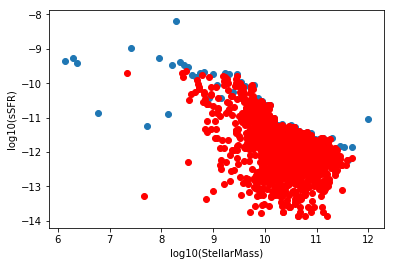

umber of final sample 1416
6373 len_sel
len(ra) after masking 2865
lencra 2865
2865
median of sm 10.442916870117188
min(zred) 0.006813006475567818
midian(zred) 0.16768011450767517
Selecting 2865 samples 


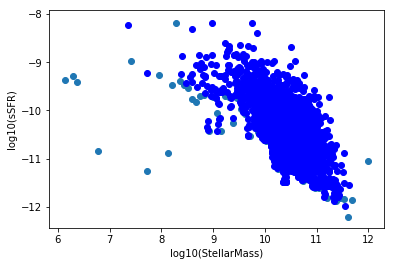

umber of final sample 1416


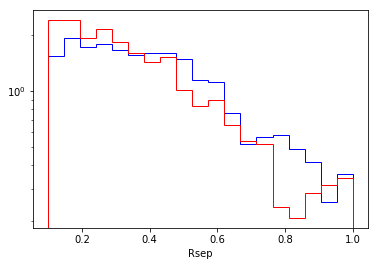

median of sfr -10.385630130767822


In [93]:
lra, ldec, lred, lwgt, lid, sfr, mrsepL = lens_select(Rmin=0.1, Rmax=1, mirror=False, HighSM=False) #here HighSM is highsSFR
lra, ldec, lred, lwgt, lid, sfr, mrsepH = lens_select(Rmin=0.1, Rmax=1, mirror=False, HighSM=True) #here HighSM is highsSFR

plt.hist(mrsepH, bins=np.linspace(0.1, 1, 20), edgecolor='b', histtype='step', density = True)
plt.hist(mrsepL, bins=np.linspace(0.1, 1, 20), edgecolor='r', histtype='step', density = True)
plt.yscale('log')
plt.xlabel('Rsep')
# plt.hist(mrsepH)
# plt.hist(mrsepL)
plt.show()
print('median of sfr',np.median(sfr))
# plt.figure(figsize=(8, 6), dpi=300)
# # ys = np.linspace(10.2, 11.5, 1000)
# # xs = np.linspace(0.04, 0.34, 1000)
# # plt.plot(xs, [10.2]*1000, c = 'k')
# # plt.plot([0.04]*1000, ys, c = 'k')
# # plt.plot(xs, [11.5]*1000, c = 'k')
# # plt.plot([0.34]*1000, ys, c = 'k')
# plt.ylim(min(sm1), max(sm1))
# plt.scatter(lred, sm1, s = 3)
# plt.ylim(0,1e-10)
# plt.xlabel('Redshift')
# plt.ylabel('log(stellar mass)')
# plt.show()
